# Predicting the price of Bitcoin, intro to LSTM


In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns

## Data Exploration

In [5]:
data = pd.read_csv("data/BTC_USD_1603360546488.csv", names=['Date', 'Close'])
data = data.sort_values('Date')
data.head()

,Date,Close
0,2019-12-27 12:00,7066.60
1,2019-12-27 13:00,7175.70
2,2019-12-27 14:00,7163.31
3,2019-12-27 15:00,7183.10
4,2019-12-27 16:00,7217.40


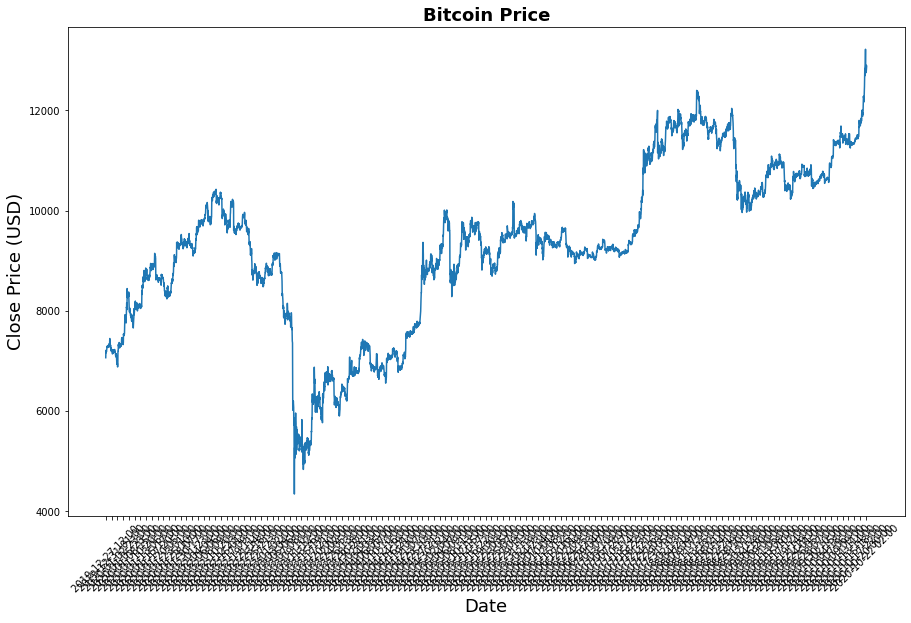

In [6]:
price = data[['Close']]

plt.figure(figsize = (15,9))
plt.plot(price)
plt.xticks(range(0, data.shape[0],50), data['Date'].loc[::50],rotation=45)
plt.title("Bitcoin Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [7]:
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6609 entries, 0 to 6608
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   6609 non-null   float64
dtypes: float64(1)
memory usage: 103.3 KB


## Data Preparation

### Normalization

In [8]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

norm_data = min_max_scaler.fit_transform(price.values)

In [9]:
print(f'Real: {price.values[0]}, Normalized: {norm_data[0]}')
print(f'Real: {price.values[500]}, Normalized: {norm_data[500]}')
print(f'Real: {price.values[1200]}, Normalized: {norm_data[1200]}')

Real: [7066.6], Normalized: [0.30648021]
Real: [8633.5], Normalized: [0.48306555]
Real: [9898.8], Normalized: [0.62566139]


### Data split

In [10]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

past_history = 50
future_target = 0

TRAIN_SPLIT = int(len(norm_data) * 0.8)


x_train, y_train = univariate_data(norm_data,
                                   0,
                                   TRAIN_SPLIT,
                                   past_history,
                                   future_target)

x_test, y_test = univariate_data(norm_data,
                                 TRAIN_SPLIT,
                                 None,
                                 past_history,
                                 future_target)

## Build the model

In [11]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, LSTM, LeakyReLU, Dropout

num_units = 64
learning_rate = 0.0001
activation_function = 'sigmoid'
adam = Adam(lr=learning_rate)
loss_function = 'mse'
batch_size = 5
num_epochs = 50

# Initialize the RNN
model = Sequential()
model.add(LSTM(units = num_units, activation=activation_function, input_shape=(None, 1)))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.1))
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer=adam, loss=loss_function)

Using TensorFlow backend.


In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [13]:
# Using the training set to train the model
history = model.fit(
    x_train,
    y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=num_epochs,
    shuffle=False
)

Train on 4713 samples, validate on 524 samples
Epoch 1/50
4713/4713 [==============================] - 16s 3ms/step - loss: 0.1663 - val_loss: 0.0244
Epoch 2/50
4713/4713 [==============================] - 15s 3ms/step - loss: 0.0343 - val_loss: 0.0146
Epoch 3/50
4713/4713 [==============================] - 15s 3ms/step - loss: 0.0300 - val_loss: 0.0107
Epoch 4/50
4713/4713 [==============================] - 15s 3ms/step - loss: 0.0241 - val_loss: 0.0111
Epoch 5/50
4713/4713 [==============================] - 15s 3ms/step - loss: 0.0206 - val_loss: 0.0153
Epoch 6/50
4713/4713 [==============================] - 15s 3ms/step - loss: 0.0175 - val_loss: 0.0087
Epoch 7/50
4713/4713 [==============================] - 15s 3ms/step - loss: 0.0158 - val_loss: 0.0081
Epoch 8/50
4713/4713 [==============================] - 15s 3ms/step - loss: 0.0143 - val_loss: 0.0137
Epoch 9/50
4713/4713 [==============================] - 15s 3ms/step - loss: 0.0120 - val_loss: 0.0107
Epoch 10/50
4713/4713 [===

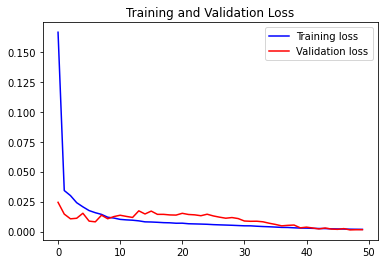

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

## Prediction
For each of the items we used for the validation, let's now predict them so we can compare how well we did.

[]

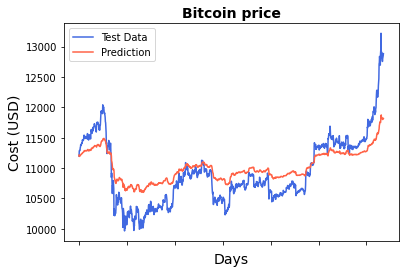

In [15]:
original = pd.DataFrame(min_max_scaler.inverse_transform(y_test))
predictions = pd.DataFrame(min_max_scaler.inverse_transform(model.predict(x_test)))

ax = sns.lineplot(x=original.index, y=original[0], label="Test Data", color='royalblue')
ax = sns.lineplot(x=predictions.index, y=predictions[0], label="Prediction", color='tomato')
ax.set_title('Bitcoin price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)